Pedro Ivo Vasconcelos - TP

## **Capítulo 8**
1) Para responder isto é necessário verificar se os estados $x_{2}$ e $x_{3}$ são controláveis

$C_{trb}$\=\[B $O_{bsv}$ B  $O_{bsv}$<sup>2</sup>B ⋯ $O_{bsv}$<sup>n−1</sup>B\]

In [3]:
import numpy as np
import math
import control as ctl
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import matrix_rank
from scipy.signal import place_poles

# Definindo a matriz A e a matriz C
A = np.diag([0.031, 0.791, 0.791, 1.0, 1.0, 1.0, 1.0])
C = np.array([
    [0, 1, 0, 0, 0, 0, 0],  # x2
    [0, 0, 1, 0, 0, 0, 0]   # x3
])

# Definindo a matriz B
B = np.array([
    [0.1545, 0.1545],
    [2.47e-4, -2.49e-4],
    [-4.56e-5, -4.15e-5],
    [-0.0303, 0],
    [0, 0],
    [0, -0.0303],
    [0, 0]
])

# Construindo a matriz de controlabilidade
ctrb = B
for i in range(1, A.shape[0]):
    ctrb = np.hstack((ctrb, np.linalg.matrix_power(A, i) @ B))

# Calculando o posto da matriz obsv_ctrb
rank_of_controllability = matrix_rank(ctrb)
print("Posto da matriz de controlabilidade dos estados observáveis:", rank_of_controllability)

if rank_of_controllability == A.shape[0]:
    print("A matriz é completamente controlável.")
else:
    print("A matriz não é ou é parcialmente controlável.")

Posto da matriz de controlabilidade dos estados observáveis: 5
A matriz não é ou é parcialmente controlável.


Voltando analisar o problema de controlabilidade, como está na forma de Jordan dois estados pela matriz b não estão sendo alimentados por nenhuma entrada, então são estados não controláveis, e portanto não compõem a saída do sistema.

Além disso apenas dois estados compõem a saída e são observáveis.

Uma diferença da forma de Jordan para as outras formas canônicas é que a controlabilidade e observabilidade porem ser analisadas apenas analisando as matrizes.


In [4]:
#Recriando a matriz A, B e C removendo estes estados
A_reduzido = A = np.diag([0.791, 0.791])
B_reduzido = np.array([
    [2.47e-4, -2.49e-4],
    [-4.56e-5, -4.15e-5],
])
C_reduzido = np.array([
    [1, 0],  # x2
    [0, 1]   # x3
])

# Construindo a matriz de controlabilidade
ctrb = B_reduzido
for i in range(1, A_reduzido.shape[0]):
    ctrb = np.hstack((ctrb, np.linalg.matrix_power(A_reduzido, i) @ B_reduzido))

# Calculando o posto da matriz obsv_ctrb
rank_of_controllability = matrix_rank(ctrb)
print("Posto da matriz de controlabilidade dos estados observáveis:", rank_of_controllability)

if rank_of_controllability == A_reduzido.shape[0]:
    print("A matriz é completamente controlável.")
else:
    print("A matriz não é ou é parcialmente controlável.")

Posto da matriz de controlabilidade dos estados observáveis: 2
A matriz é completamente controlável.


2. 

In [5]:
#Utilizando as matrizes reduzidas e usando um dos pólos
T = 40
lambda_atual = 0.791
s = 1/T * math.log(lambda_atual)
# Nova constante de tempo desejada (duplicando a velocidade de resposta)
s_novo = s*2
lambda_novo = math.exp(s_novo*T)
print("Opção de cálculo 1:", lambda_novo)
# Outra forma de calcular a constante de tempo por conta de z = e^(sT) logo z_novo = e^(s*2*T)
print("Opção de cálculo 2:", lambda_atual**2)
#A nova matriz A será:
A_novo = np.diag([lambda_novo, lambda_novo])
print(A_novo)

Opção de cálculo 1: 0.625681
Opção de cálculo 2: 0.625681
[[0.625681 0.      ]
 [0.       0.625681]]


3. Malha aberta

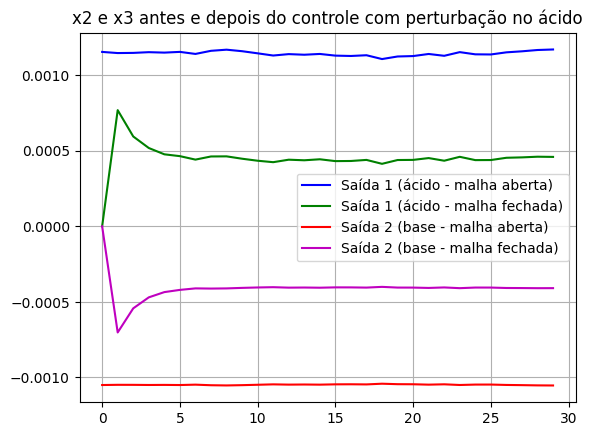

In [6]:
from scipy.signal import place_poles
A_reduzido = np.diag([0.791, 0.791])
B_reduzido = np.array([
    [2.47e-4, -2.49e-4],
    [-4.56e-5, -4.15e-5],
])
C_reduzido = np.array([
    [1, 0],  # x2
    [0, 1]   # x3
])
A_novo = np.diag([0.625681, 0.625681])

# Entradas no ponto de operação
u_op = np.array([3, 2])
N = 30
u = np.zeros((2, N))

# Perturbação na vazão de ácido
u[0,0] = 3
u[0,:] = 3 + np.random.normal(0, 0.05, N)
# Vazão de base forte constante
u[1,0] = 2
u[1,:] = 2

# Ponto de operação calculado
I = np.eye(A_reduzido.shape[0])
x_op = np.linalg.inv(I - A_reduzido) @ (B_reduzido @ u_op)

# Simulação do sistema partindo do ponto de operação
x = x_op  # Inicializando no ponto de operação
x_hist = np.zeros((2, N))
y_hist = np.zeros((2, N))

for k in range(N):
    # Atualizando os estados
    x = np.dot(A_reduzido, x) + np.dot(B_reduzido, u[:, k])
    y = np.dot(C_reduzido, x)
    x_hist[:, k] = x
    y_hist[:, k] = y

# Controlador
desired_poles = [0.625681, 0.625681]
place = place_poles(A_reduzido, B_reduzido, desired_poles)
Kc = place.gain_matrix

# Simulação do sistema em malha fechada
x_cl = np.zeros((2, N))
y_cl = np.zeros((2, N))

# Inicializando o sistema em malha fechada no ponto de operação
x_cl[:, 0] = x_op

for k in range(1, N):
    # Sistema em malha fechada
    x_cl[:, k] = np.dot(A_novo - B_reduzido @ Kc, x_cl[:, k-1]) + B_reduzido @ u[:, k]
    y_cl[:, k] = np.dot(C_reduzido, x_cl[:, k])

# Plot dos resultados
plt.plot(range(N), y_hist[0], '-b', label='Saída 1 (ácido - malha aberta)')
plt.plot(range(N), y_cl[0], '-g', label='Saída 1 (ácido - malha fechada)')
plt.plot(range(N), y_hist[1], '-r', label='Saída 2 (base - malha aberta)')
plt.plot(range(N), y_cl[1], '-m', label='Saída 2 (base - malha fechada)')
plt.title('x2 e x3 antes e depois do controle com perturbação no ácido')
plt.legend()
plt.grid()
plt.show()


O sistema responde mais rápido quando é controlado, além da saída ter uma resposta mais atenuada.

4.

No caso do ácido controlado(MF) ele levou 5 ciclos aproximadamente para estabilizar próximo de 0.0005 seguindo uma variação quase proporcional a MA, e ocorre o mesmo no caso da base. Ainda é necessário corrigir este controle para que as saídas sigam as entradas, que seria as linhas verde e roxa estarem bem próximas.

5. O observador com dois estados será da forma:
cT =
$\begin{bmatrix}
1 & 0  \\
0 & 0.5
\end{bmatrix}$
Que é o mesmo formato do C_reduzido usado nos exemplos anteriores

In [7]:
# Definindo a matriz A e C reduzida para o sistema discreto
A_r = np.array([
    [0.791, 0],
    [0, 0.791]
])
# É necessário usar outra saída porque c.c. o sistema é inobservável
C_r = np.array([[1, 0], [0, 0.5]])

n = A_r.shape[0]
observ_matrix = C_r
for i in range(1, n):
    observ_matrix = np.vstack((observ_matrix, C_r @ np.linalg.matrix_power(A_r, i)))

rank_of_observability = matrix_rank(observ_matrix)
if A_r.shape[0] == rank_of_observability:
    desired_poles = np.poly([0.5, 0.4])
    A_poly = np.poly(np.linalg.eigvals(A_r))
    f_A = desired_poles - A_poly

    observ_matrix = np.vstack([C_r, C_r @ A_r])
    inv_observ_matrix = np.linalg.inv(observ_matrix[:2, :2])
    L = np.dot(inv_observ_matrix, f_A[1:])
    print("Vetor de ganhos:", L)
else:
    print("O sistema não é completamente observável desta forma.")

Vetor de ganhos: [ 0.682    -0.851362]


6. Código ajustado de smirk_ph_CD.py

C:\Users\pedro.vasconcelos\AppData\Local\Temp\ipykernel_4772\4096441479.py:152: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m[k-1] = -np.dot(Kc, x_observed[:, k-1])


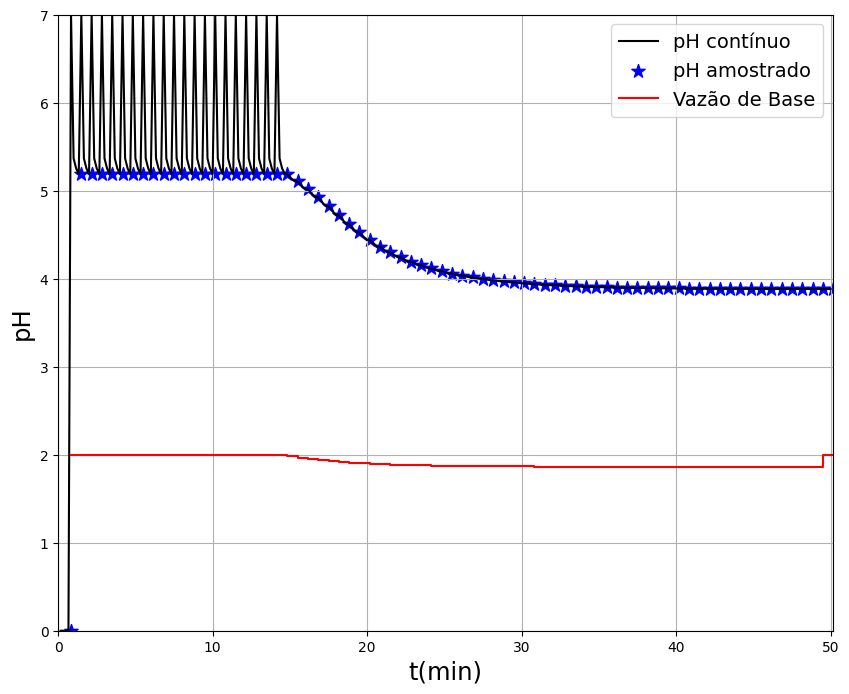

In [8]:
# Pacotes utilizados
import numpy as np
import matplotlib.pyplot as plt

#**************************************************************************
#* Simulacao de malha de controle digital: planta de neutralizacao de pH  *
#**************************************************************************

#%% Definição dos parâmetros para o modelo de pH
ka1 = 10**-6.35  # ka1=[HCO3-][H+]/[H2CO3-]
ka2 = 10**-10.33 # ka2=[CO3^2-][H+]/[HCO3-]
kw  = 10**-14    # kw1=[H+][OH-]
Kas = np.array([ka1, ka2, kw])

# Condicoes Iniciais de H, Wa, Wb, Hta, Htt, Htb e Htc
x0 = np.array([12.3, 10**-14, 0, 45.45, 36.37, 45.45, 0])

# Constantes do modelo Q1, Q2, Q3, Q4, A, c, h0, wa1, wa2, wa3, wb1, wb2, wb3
Q2 = 0.1 # Vazao de tampao em mL/seg
Q4 = 0   # Vazao de saida
Ar = 72  # Area da base do reator
Vr = 870
Ata = 1320 # Area da base do tanque de reagente acido (cm^2)
Att = 1320 # Area da base do tanque de reagente tampao (cm^2)
Atb = 1320 # Area da base do tanque de reagente base (cm^2)
Atc = 1963.5 # Area da base do tanque de coletor (cm^2)
c = 8    # Constante da valvula de saida (Q4)
h0 = 5   # Altura para diferencial de pressao saida do tanque
wa1 = 0.006    # concentracao acida em Q1 -> [HNO3] 
wa2 = -0.06    # concentracao acida em Q2 -> -[NaHCO3]
wa3 = -0.0061  # concentracao acida em Q3 -> -[NaHCO3]-[NaOH]
wb1 = 0        # concentracao base em Q1
wb2 = 0.06     # concentracao base em Q2 -> [NaHCO3]
wb3 = 0.0001   # concentracao base em Q3 -> [NaHCO3]
par = np.array([Q2, Q4, Ar, Vr, Ata, Att, Atb, Atc, c, h0, wa1, wa2, wa3, wb1, wb2, wb3])

#%% Funções auxiliares
def rkpH(x0,ux,uy,h,t,par):
    xd = dvpH(x0,ux,uy,t,par)
    savex0 = x0
    phi = xd
    x0 = savex0 + 0.5*h*xd
    
    xd = dvpH(x0,ux,uy,t+0.5*h,par)
    phi = phi + 2*xd
    x0 = savex0 + 0.5*h*xd
    
    xd = dvpH(x0,ux,uy,t+0.5*h,par)
    phi = phi + 2*xd
    x0 = savex0 + h*xd
    
    xd = dvpH(x0,ux,uy,t+h,par)
    x = savex0 + (phi+xd)*h/6
    return x

def dvpH(x,ux,uy,t,par):
    xd = np.zeros(7)
    xd[0] = (ux + par[0] + uy - (par[8]*(np.sqrt(x[0]-par[9])))) / par[2]
    xd[1] = ((ux*(par[10]-x[1])) + (par[0]*(par[11]-x[1])) + (uy*(par[12]-x[1]))) / par[3]
    xd[2] = ((ux*(par[13]-x[2])) + (par[0]*(par[14]-x[2])) + (uy*(par[15]-x[2]))) / par[3]
    xd[3] = -ux/par[4]
    xd[4] = -par[0]/par[5]
    xd[5] = -uy/par[6]
    xd[6] = par[1]/par[7]
    return xd

def simrk_pH(x0,u1,u2,h,t,par,Kas,Ts):
    xc = np.zeros((len(x0),int(Ts/h)))
    pHc = np.zeros(int(Ts/h))
    xc[:,0] = x0
    coeff = [1, Kas[0] - xc[1,0], Kas[0]*Kas[1]-Kas[0]*xc[1,0]-Kas[2]-Kas[0]*xc[2,0],
             -(Kas[0]*Kas[2]+Kas[0]*Kas[1]*xc[1,0]+2*Kas[0]*Kas[1]*xc[2,0]), 
             -Kas[0]*Kas[1]*Kas[2]]
    p = np.roots(coeff)
    ch = np.max(np.real(p))
    pHc[0] = -np.log10(ch)
    
    for i in range(1, int(Ts/h)):
        xc[:,i] = rkpH(xc[:,i-1],u1,u2,h,t,par)
        t = t + h
        coeff = [1, Kas[0] - xc[1,i], Kas[0]*Kas[1]-Kas[0]*xc[1,i]-Kas[2]-Kas[0]*xc[2,i],
                 -(Kas[0]*Kas[2]+Kas[0]*Kas[1]*xc[1,i]+2*Kas[0]*Kas[1]*xc[2,i]), 
                 -Kas[0]*Kas[1]*Kas[2]]
        p = np.roots(coeff)
        ch = np.max(np.real(p))
        pHc[i] = -np.log10(ch)
    
    x = xc[:,i]
    pH = pHc[i]
    
    return {'x': x, 'pH': pH, 'xc': xc, 'pHc': pHc}

#%% Configurações da simulação
h = 10  # Intervalo de integração
t0 = h  # Tempo inicial
tm = 50 # Tempo de simulação (min)
tf = 60 * tm  # Tempo total de simulação (s)
tr = 60 * 15  # Instante de mudança de referência (min)
td = 60 * 10  # Instante de aplicação do distúrbio (min)
t = np.arange(t0, tf + h, h)  # Vetor de tempo contínuo
Ts = 40  # Tempo de amostragem (discreto)

# Vetor de tempo discreto
T = t[::int(Ts/h)]

# Constantes do controlador e do observador
Kc = np.array([[0.05, -0.03]])  # Ganhos de controle (ajuste conforme necessário)
L = np.array([[0.1], [0.05]])   # Ganhos do observador (ajuste conforme necessário)

# Definindo o ponto de operação e entradas
Q1 = 3 * np.ones(len(T))  # Vazão de ácido forte
Q3 = 2 * np.ones(len(T))  # Vazão de base forte
d1 = np.zeros(len(T))     # Distúrbio
r = 5 * np.ones(len(T))    # Setpoint (pH)
e = np.zeros(len(T))       # Erro
m = np.zeros(len(T))       # Ação de controle
u1 = Q1.copy()             # Entrada ácido
u2 = Q3.copy()             # Entrada base

# Inicialização das matrizes de estados e observador
x = np.zeros((7, len(T)))  # Estados do sistema
pH = np.zeros(len(T))      # Valores de pH ao longo do tempo (discreto)
pHc = np.zeros(len(t))     # Valores de pH ao longo do tempo contínuo
x_observed = np.zeros((2, len(T)))  # Estados observados (x2 e x3)
xc = np.zeros((7, len(t)))  # Estados contínuos

# Regime transiente (10 minutos)
for k in range(1, int(np.floor(tr/Ts))+1):
    kc = int(k * Ts / h)
    simrk_pH_dict = simrk_pH(x0, Q1[k], Q3[k], h, t[kc], par, Kas, Ts)
    x[:, k] = simrk_pH_dict['x']
    pH[k] = simrk_pH_dict['pH']
    pHc[kc:kc + int(Ts/h)] = simrk_pH_dict['pHc']  # Atualizando pH contínuo
    xc[:, kc:kc + int(Ts/h)] = simrk_pH_dict['xc']  # Atualizando estados contínuos

# Período de testes com controle
ini = k
r[ini:] = 5.5 * np.ones(len(T) - ini)  # Mudança de setpoint
d1[ini+int(np.floor(td/Ts)):] = 0.3 * np.ones(len(T) - ini - int(np.floor(td/Ts)))

# Simulação com controle baseado no observador
for k in range(ini, len(T)):
    # Estimar estados usando o observador
    y_observed = np.dot(C_r, x_observed[:, k-1])  # Saída observada
    error_in_observation = pH[k-1] - y_observed[0]  # Usar a primeira saída observada (associada ao pH)
    
    # Atualização do estado observado
    x_observed[:, k] = x_observed[:, k-1] + L @ np.array([error_in_observation])
    
    # Calculando o erro e ação de controle
    e[k-1] = r[k-1] - pH[k-1]
    m[k-1] = -np.dot(Kc, x_observed[:, k-1])
    u2[k-1] = Q3[k-1] + m[k-1]
    
    # Simular planta com novo valor de entrada
    kc = int(k * Ts/h)
    simrk_pH_dict = simrk_pH(x[:, k-1], u1[k-1], u2[k-1], h, t[kc], par, Kas, Ts)
    x[:, k] = simrk_pH_dict['x']
    pH[k] = simrk_pH_dict['pH']
    pHc[kc:kc + int(Ts/h)] = simrk_pH_dict['pHc']  # Atualizando pH contínuo
    xc[:, kc:kc + int(Ts/h)] = simrk_pH_dict['xc']  # Atualizando estados contínuos

# Plot dos resultados
plt.figure(1, figsize=(10, 8))
plt.plot(t/60, pHc, color='black', linewidth=1.5, label='pH contínuo')
plt.scatter((T+Ts)/60, pH, color='blue', marker='*', s=100, label='pH amostrado')         
plt.step((T+Ts)/60, u2, color='red', linewidth=1.5, label='Vazão de Base')
plt.xlim(0, (t[-1]+h)/60)
plt.ylim(0, 7)
plt.xlabel('t(min)', fontsize=17.5)
plt.ylabel('pH', fontsize=17.5)
plt.legend(fontsize=14)
plt.grid()
plt.show()